In [2]:
import sys
import actorcritic as ac
import environment as gw
import memory as ec

sys.modules['gw'] = gw
sys.modules['ac'] = ac
# TODO -- need to do this for all imported modules????

import run_experiment as expt

import pickle
import argparse
import pandas as pd
import uuid
from analysis import DataFilter
## remove after july 24
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
def main(experiment_type, env_type, rho, arch, use_pvals, mem_temp, mem_envelope, alpha, beta, RECORD=True):
    parent_dir = './data/'
    log_file = 'cottage_scinet_logs.csv'
    # set environment parameters
    rows, columns = 20, 20
    penalty = -0.01
    if experiment_type == 0:
        reward_location = (5, 5)
    else:
        reward_location = (15, 15)
    print(experiment_type, reward_location, "arg")

    # generate environment object
    env = gw.GridWorld(rows=rows, cols=columns, env_type=env_type,
                       rewards={reward_location: 1},
                       step_penalization=penalty,
                       rho=rho,
                       actionlist=['Down', 'Up', 'Right', 'Left'],
                       rewarded_action=None)

    # agent parameters
    training = {
        'load_model': False,
        'load_dir': '',

        'architecture': arch,
        'input_dims': env.observation.shape,
        'action_dims': len(env.action_list),
        'hidden_types': ['conv', 'pool', 'conv', 'pool', 'linear', 'linear'],
        'hidden_dims': [None, None, None, None, 100, 200],

        'freeze_w': False,

        'rfsize': 5,

        'gamma': 0.98,
        'eta': 5e-4,

        'use_EC': False
    }

    testing_1 = training.copy()
    testing_1.update({'load_model': True, 'freeze_w': True})

    testing_2 = testing_1.copy()
    testing_2.update({'use_EC': True})

    testing_4 = testing_1.copy()
    testing_4.update({'freeze_w': False})

    testing_5 = testing_4.copy()
    testing_5.update({'use_EC': True})

    params = [training, testing_1, testing_2, testing_2, testing_4, testing_5, testing_5]

    NUM_TRIALS = 100
    NUM_EVENTS = 50

    # mixing parameters for MF-EC control
    # alpha = 0.01 # MF confidence boost for reward
    # beta = 100 # MF confidence decay - number of steps to decay to 1%

    # create an agent with parameters for a given experiment type
    agent_params = params[experiment_type]
    load_id = ' '
    if experiment_type != 0:
        # read csv file - get id tag for matching conditions
        df = pd.read_csv(parent_dir + log_file)
        filter = DataFilter(df,
                            expt_type=[0],
                            env_type=[str(env_type)],
                            dims=[str(env.shape)],
                            rho=[float(env.rho)],
                            arch=[arch])

        load_id = list(filter.ids)[0]
        agent_params['load_dir'] = parent_dir + f'agent_weights/{load_id}.pt'
        print(load_id)
        env = pickle.load(open(parent_dir + f'environments/{load_id}_env.p', 'rb'))
        
        # set new reward location and update env.R accordingly 
        env.rewards = {reward_location: 1}
        env.buildRewardFunction()
        env.finish_after_first_reward = False

    # create agent from parameters for given experiment type
    agent = ac.make_agent(agent_params)

    if experiment_type in [2, 3, 5, 6]:
        # create memory module
        mem = ec.EpisodicMemory(cache_limit=0.75 * env.nstates,
                                entry_size=agent.action_dims,
                                mem_temp=mem_temp,
                                mem_envelope=mem_envelope,
                                pvals=use_pvals)
    else:
        mem = None
    # create run_id
    run_id = uuid.uuid4()
    # create experiment object
    ex = expt.Experiment(agent, env, use_mem=agent_params['use_EC'], mem=mem)

    # run experiment
    ex.run(NUM_TRIALS, NUM_EVENTS, alpha=alpha, beta=beta)

    # log data
    if RECORD:
        expt.data_log(run_id, experiment_type, ex, load_from=load_id)

    return ex



In [46]:
experiment_type = 2
env_type = None
rho = 0.0
arch = 'B'
use_pvals = False
mem_temp = 0.05
mem_envelope = 50

alpha = 1
beta = 1000




ex = main(experiment_type, env_type, rho, arch, use_pvals, mem_temp, mem_envelope, alpha, beta, RECORD=False)

2 (15, 15) arg
59bdc055-56f7-4095-afe6-bc0286f99dff
output.0.weight
output.0.bias
output.1.weight
output.1.bias
SR.weight
SR.bias
running alpha 1, beta: 1000
MF:0/EC:50 || R:-0.5000000000000002 
0: -0.5000000000000002 (0.13699603080749512s)
MF:0/EC:50 || R:-0.5000000000000002 
MF:18/EC:32 || R:0.5099999999999998 
MF:44/EC:6 || R:-0.5000000000000002 
MF:35/EC:15 || R:-0.5000000000000002 
MF:26/EC:24 || R:-0.5000000000000002 
MF:21/EC:29 || R:-0.5000000000000002 
MF:9/EC:41 || R:-0.5000000000000002 
MF:15/EC:35 || R:-0.5000000000000002 
MF:40/EC:10 || R:0.5099999999999997 
MF:35/EC:15 || R:-0.5000000000000002 
10: -0.5000000000000002 (5.716389179229736s)
MF:44/EC:6 || R:0.5099999999999997 
MF:37/EC:13 || R:-0.5000000000000002 
MF:30/EC:20 || R:-0.5000000000000002 
MF:20/EC:30 || R:-0.5000000000000002 
MF:14/EC:36 || R:-0.5000000000000002 
MF:11/EC:39 || R:-0.5000000000000002 
MF:8/EC:42 || R:-0.5000000000000002 
MF:16/EC:34 || R:0.5099999999999998 
MF:44/EC:6 || R:-0.5000000000000002 
MF

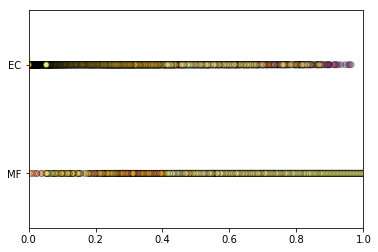

<Figure size 432x288 with 0 Axes>

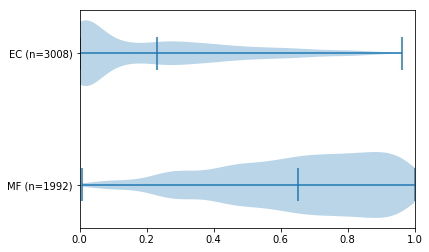

In [47]:
#### trying some craziness -- delete later (Jul 24)
plt.figure()
x = ex.data['confidence_selection'][0] # MFCS
y = ex.data['confidence_selection'][1] # policy_choice
viridis = cm.get_cmap('inferno', len(x)).colors
plt.scatter(x, y, c = viridis, alpha=0.3, edgecolor='k')
plt.yticks([0,1], ['MF', 'EC'])
plt.ylim([-0.5, 1.5])
plt.xlim([0,1])
plt.show()
plt.close()

plt.figure()
x = ex.data['confidence_selection'][0] # MFCS
y = ex.data['confidence_selection'][1] # policy_choice
viol = [[],[]] #mf ec
for ind, i in enumerate(x):
    viol[y[ind]].append(i)
    
plt.figure()
plt.violinplot(viol, positions = [0,1], vert=False, showmeans=True)
plt.xlim([0,1])
plt.yticks([0,1], [f'MF (n={len(viol[0])})', f'EC (n={len(viol[1])})'])
plt.show()
plt.close()



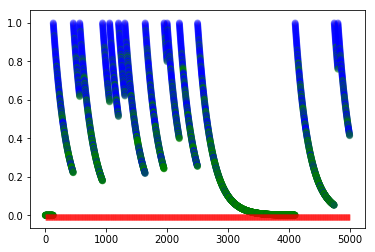

In [50]:
plt.figure()
y = ex.data['confidence_selection'][0] # MFCS
x = np.arange(len(y))
cols = ['b', 'g'] #mf , ec
z = ex.data['confidence_selection'][1] # policy_choice
col = [cols[i] for i in z]

plt.scatter(x, y, c = col, alpha=0.3)
plt.plot(ex.data['all_r'], 'r|', alpha = 0.1)
plt.show()
plt.close()
